<a href="https://colab.research.google.com/github/Kwanikaze/vpandas/blob/master/MRF_VAE_binary_vars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from torch.distributions.multivariate_normal import MultivariateNormal

!pip install pgmpy==0.1.9
import pgmpy
import networkx as nx
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination

!pip install -i https://test.pypi.org/simple/ PPandas==0.0.1.7.1
!pip install python-intervals
!pip install geopandas
!pip install geovoronoi
import ppandas
from ppandas import PDataFrame

Looking in indexes: https://test.pypi.org/simple/


# Load Data and Create Sample Datasets

In [2]:
# Function to create OHE dataset for specified attributes given a global df
def OHE_sample(sample_df, features_to_OHE: list):
  for feature in features_to_OHE:
    feature_OHE = pd.get_dummies(prefix = feature,data= sample_df[feature])
    sample_df = pd.concat([sample_df,feature_OHE],axis=1)
  sample_df.drop(features_to_OHE,axis=1,inplace=True)
  print(sample_df)
  return sample_df

In [3]:
#Hardcode 2x2 P(A,B)
# Load global relation from github
from numpy import genfromtxt
data_2 = genfromtxt('https://raw.githubusercontent.com/Kwanikaze/vpandas/master/data_2.csv?token=ADHT6UCKSGOEANAAQWTKGL3ACDPPS', delimiter=',',skip_header=1)
data_2_1000 = np.tile(data_2, (100, 1))
mean = np.mean(data_2_1000, axis=0)
cov = np.cov(data_2_1000, rowvar=0)
print("Mean Vector")
print(mean)
print("Covariance Matrix")
print(cov)
#print(data_2.shape)
#print(data_2_1000.shape)
df = pd.DataFrame(pd.np.tile(data_2, (100, 1)))
df.columns=['A','B']
df=df.astype(int)
#print(df)
#df.to_csv('data_2_1000rows.csv',index=False)


#df = pd.read_csv("data_2_1000rows.csv") # 3columns A,B,C that each contain values 0 to 1, block diagonal
print(df.shape)

#Create two datasets containing AB and BC
num_samples = 500
sample1_df = df[['A','B']].sample(n=num_samples, random_state=2)
print(sample1_df.shape)
print(sample1_df.head())
#sample2_df = df[['B','C']].sample(n=num_samples, random_state=3)
#print(sample2_df.head())

# Make A,B,C inputs all 8 bits
#Could add noise so not exactly OHE: 0.01...0.9...0.01
sample1_OHE = OHE_sample(sample1_df,['A','B'])
#sample2_OHE = OHE_sample(sample2_df,['B','C'])

# Could onvert pandas dataframes to list of lists of lists
# [ [[OHE A1],[OHE B1]], [[OHE A2],[OHE B2]], ...  ]

Mean Vector
[0.6 0.5]
Covariance Matrix
[[0.24024024 0.1001001 ]
 [0.1001001  0.25025025]]
(1000, 2)
(500, 2)
     A  B
37   1  1
726  1  1
846  1  1
295  1  0
924  1  0
     A_0  A_1  B_0  B_1
37     0    1    0    1
726    0    1    0    1
846    0    1    0    1
295    0    1    1    0
924    0    1    1    0
..   ...  ...  ...  ...
194    0    1    1    0
136    0    1    0    1
581    1    0    1    0
662    1    0    1    0
671    1    0    1    0

[500 rows x 4 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  


# Global Relation Bayesian Network Ground Truth

P(A,B) = 
*   P(A=0,B=0) = 0.3
*P(A=0,B=1) = 0.1
*P(A=1,B=0) = 0.2
*P(A=1,B=1) = 0.4







 P(B|A=0) Ground Truth


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


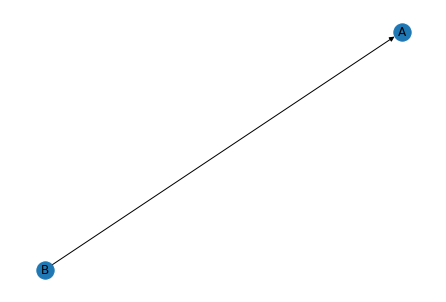

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


 Global Relation Ground Truth
+------+----------+
| B    |   phi(B) |
+======+==========+
| B(0) |   0.7500 |
+------+----------+
| B(1) |   0.2500 |
+------+----------+

 P(A|B=0) Ground Truth


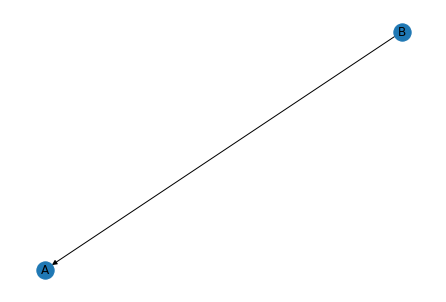

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


 Global Relation Ground Truth
+------+----------+
| B    |   phi(B) |
+======+==========+
| B(0) |   0.3333 |
+------+----------+
| B(1) |   0.6667 |
+------+----------+


In [4]:
def groundTruth(df,query_attribute,evidence):
    """
    Extracts ground truth from global relation
    """
    model = BayesianModel([('B', 'A')])
    model.fit(df)
    nx.draw(model, with_labels=True)
    plt.show()
    print('\n Global Relation Ground Truth')
    #for var in model.nodes():
    #    print(model.get_cpds(var))
    inference = VariableElimination(model)
    
    #q = inference.query(variables=['A','B','C'])
    #joint_prob = q.values.flatten()
    #print(joint_prob)
    #print('\n P(A,B,C) \n Ground Truth')
    #print(q)
    q = inference.query(variables=[query_attribute], evidence=evidence)
    print(q)

print('\n P(B|A=0) Ground Truth')
groundTruth(df,query_attribute = 'B', evidence = {'A':0})

print('\n P(A|B=0) Ground Truth')
groundTruth(df,query_attribute = 'B', evidence = {'A':1})

# ppandas

In [5]:
def ppandas_query(sample1_df,num_samples,query_attribute,evidence):
    pd1 = PDataFrame(['B'],sample1_df)
    q = pd1.query(['A','B'])
    cols = q.columns.tolist()
    q = q.rename(columns={q.columns[2]:'Probability(A,B)'})
    #Reorder columns
    q = q[['A','B','Probability(A,B)']]
    q= q.sort_values(by=['A','B'])
    #print(q)
    #Sort rows in dataframe by descending order
    print("\n ppandas P({}|{}) , n={} \n ".format(query_attribute,evidence,num_samples))
    q1 = pd1.query([query_attribute],evidence_vars=evidence)
    print(q1)
    q1 = pd1.map_query([query_attribute],evidence_vars=evidence)
    #pd_join.visualise()
    return q1

q1 = ppandas_query(sample1_df,num_samples,query_attribute='B',evidence={'A':0})
q1 = ppandas_query(sample1_df,num_samples,query_attribute='B',evidence={'A':1})
#print(ppandas_C)


 ppandas P(B|{'A': 0}) , n=500 
 
     B  Probability(B)
0  0.0        0.770732
1  1.0        0.229268

 ppandas P(B|{'A': 1}) , n=500 
 
     B  Probability(B)
0  0.0        0.318644
1  1.0        0.681356


# VAE-MRF Architecture

A Gaussian Markov Random Field is a Gaussian Process with a linear kernel (covariance function). $k(x,x') = x \cdot x'$


Pg 16: 
"Fortunately,
in probabilistic terms this operation is extremely simple, corresponding to conditioning the joint Gaussian prior distribution on the observations"

## Multivariate Normal
Koller Equation 7.3: \\
$P(z_A,z_B) = Normal
\left(\left( \begin{array}{r} \mu_A \\ \mu_B \end{array} \right), 
\left[ \begin{array}{r} \Sigma_{A} & \Sigma_{AB} \\ \Sigma_{BA} & \Sigma_{B} \end{array} \right] \right) $ 

which is equivalent to the Matrix Cookbook (353 and 354) https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf: \\
$P(z_A|z_B) = Normal_{z_A}(\hat{\mu}_A, \hat{\Sigma}_A)$ \\
where: \\
$\hat{\mu}_A = \mu_A + \Sigma_{AB} \Sigma_{B}^{-1}(z_B - \mu_B)$ \\
$\hat{\Sigma}_A = \Sigma_A - \Sigma_{AB} \Sigma_B^{-1} \Sigma_{AB}^T$ \\

$P(z_B|z_A) = Normal_{z_B}(\hat{\mu}_B, \hat{\Sigma}_B)$ \\
where: \\
$\hat{\mu}_B = \mu_B + \Sigma_{AB}^T \Sigma_{A}^{-1}(z_A - \mu_A)$ \\
$\hat{\Sigma}_B = \Sigma_B - \Sigma_{AB}^T \Sigma_A^{-1} \Sigma_{AB}$ \\


The output of the VAE encoders are assumed to be the mean and variance of the unary normal potentials in the MRF over the latent z's where:

•	Mean: $\mu_{A}$ and diagonal variance matrix: $\Sigma_{A}$ are the outputs of the A encoder \\
•	$\mu_{B}$,  $\Sigma_{B}$ are the outputs of the B encoder \\


The additional pairwise k-ary Normal potentials, which represent undirected graphical model structure between the latent A and latent B : \\
•	$\Sigma_{AB}$ = $\Sigma_{BA}^T$ 

If the latent space is dimension 3, each $\mu \in \mathcal{R}^{1 \times 3}$ and each $\Sigma \in \mathcal{R}^{3 \times 3}$.


#Three Options to learn Gaussian MRF (in Stage 2):
## 1. Fully Emperical
Emperically estimate $\mu_A, \mu_B, \Sigma_A$ and $\Sigma_B$ by taking sample mean of the mu and logvar output of the entire population from marginal encoders.

Emperically estimate $\Sigma_{AB}$ by using sampled z_A and z_B of the entire population (N=num_samples=500) and the sample covariance formula. Note could also use to Q formula to calculate entire covariance matrix and estimate $\Sigma_A$ and $\Sigma_B$ as well, but would be less accurate than directly using sample mean of the logvar output from the marginal encoders.

$\Sigma_{AB} = \frac{1}{N-1} (\sum_{i=1}^N (z_{i,A} - \mu_A) (z_{i,B} - \mu_B))$

Note we use more reliable $\mu_A, \mu_B$ instead of sample mean of $z_A, z_B$
https://www.itl.nist.gov/div898/handbook/pmc/section5/pmc541.htm

## 2. Fully Learned
Learn $\Sigma_A$ and $\Sigma_B$ by gradient descent which involves doing gradient descent through an inverse.

Learn $\Sigma_{AB} by gradient descent

## 3. Half Emperical Half Learned
Emperically estimate $\Sigma_A$ and $\Sigma_B$ using Option 1 to avoid gradient descent through an inverse.

Learn $\Sigma_{AB}$ using Option 2




# Training the VAE-MRF
Assuming no missing data. Training is done in two stages. The first stage learns marginal VAEs for each attribute. The second stage learns the covariance matrix $\Sigma_{AB}$ to capture the intervariable dependencies between A and B.

##Stage 1 - Marginal VAEs (Identical to Stage 1 VAEM)
Train A and B VAEs separately.
In each epoch, break the training data into batches. Each batch contains samples of OHE input $x_A$ or $x_B$:
- Feed in $x_A$ or $x_B$ to their respective encoders to obtain either:
  - $\mu_A, \Sigma_A$ from encoder A
  - $\mu_B, \Sigma_B$ from encoder B

- To reconstruct $x_A$ ($x_B$):
  - Sample $z_A$ ($z_B$) using $\mu_A, \Sigma_A$ ($\mu_B, \Sigma_B$) through standard VAE reparameterization trick
  - Feed $z_A$  ($z_B$) into the **A** (**B**) decoder to obtain the reconstruction $\hat{x}_A$ ($\hat{x}_B$)

- Sum the losses (reconstruction error and KL-divergence) from either A or B  and backpropagate once per batch.

For marginal VAEs, fix the parameters: encoder $\phi$ and decoder $\theta$.

## Stage 2 - Intervariable Dependency CRF
In each epoch, break the training data into batches. Each batch contains samples of OHE input $x_A$ and $x_B$. By reconstructing $x_A, x_B$ from $x_A$ and $x_B$, learn $\Sigma_{AB}$:
  - Feed entire batch of $x_A$ to marginal A encoder to obtain Monte Carlo emperical $\mu_A, \Sigma_A$
  - Feed entire batch of $x_B$ to marginal B encoder to obtain Monte Carlo emperical $\mu_B, \Sigma_B$
  - If memory allows - feed in entire train population of $x_A$ and $x_B$ for more reliable emperical estimates (as is done with 2 binary variables A, B and 500 samples)
  - To reconstruct a specific $x_A$:
      - Feed specific corresponding $x_B$ to marginal encoder to obtain sample $z_B$ (standard VAE reparameterization trick)
      - Using $z_B,\mu_A, \Sigma_A, \mu_B, \Sigma_B$, sample $z_A$ from $P(z_A|z_B)$ (modified VAE reparameterization trick)
      - Feed $z_A$ into the A decoder to obtain the reconstruction $\hat{x}_A$

  - To reconstruct $x_B$:
    - Feed specific corresponding $x_A$ to marginal encoder to obtain sample $z_A$ (standard VAE reparameterization trick) 
    - Using $z_A,\mu_A, \Sigma_A, \mu_B, \Sigma_B$, sample $z_B$ from $P(z_B|z_A)$ (modified VAE reparameterization trick)
    - Feed $z_B$ into the B decoder to obtain the reconstruction $\hat{x}_B$


Sum the losses (reconstruction error and KL-divergence) from both A and B and backpropagate once per batch.
Repeat for each batch. \\

Note that $\mu_A$, $\Sigma_A$, $\mu_B$, $\Sigma_B$ are fixed for each batch.  There is only one $\Sigma_{AB}$ to be shared. 

# Stage 2 - Intervariable Dependency CRF (missing data at train time scenario, not implemented)
Training the VAE-MRF on x_A only: 
- Feed entire batch of $x_A$ to marginal A encoder to obtain emperical $\mu_A, \Sigma_A$
-  Feed entire batch of $x_B$ to marginal B encoder to obtain emperical $\mu_B, \Sigma_B$ (If no $x_B$ assume prior P(zB) = Normal (0, Identity))
- Sample $z_B$ using $\mu_B, \Sigma_B$ (standard VAE reparameterization trick)
- Using $z_B,\mu_A, \Sigma_A, \mu_B, \Sigma_B$, sample $z_A$ from $P(z_A|z_B)$ (modified VAE reparameterization trick)
-  Feed $z_A$ into the A decoder to obtain the reconstruction $\hat{x}_A$ for $x_A$
- Sum the losses (reconstruction error and KL-divergence) from A and backpropagate once per batch

In [6]:
# VAE Parameters
num = 2 # digits from 0 to 1
latent_dims = 1 # Latent z_A, z_B same dimension size
num_epochs = 300
batch_size = 25
learning_rate = 1e-2 #1e-4
use_gpu = True
variational_beta = 0.0001 #tuned 0.001

batch_size_list = [25,50]
learning_rate_list = [1e-2, 1e-3, 1e-4]
variational_beta_list = [0.1,0.001,0.0001]


In [7]:
def vae_loss(batch_recon, batch_targets, mu, logvar):
  criterion = nn.CrossEntropyLoss()
  CE = criterion(batch_recon, batch_targets)
  #print(CE)
  KLd = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # https://stats.stackexchange.com/questions/318748/deriving-the-kl-divergence-loss-for-vaes
  #print(KLd)
  return CE,variational_beta*KLd, CE + variational_beta*KLd

#Train marginal VAE
def trainVAE(VAE, sample1_OHE, attribute: str):
  print("\nTraining marginal VAE for " + attribute+ " started!")
  VAE.train() #set model mode to train
  optimizer = torch.optim.Adam(params = VAE.parameters(), lr = learning_rate)
  x = sample1_OHE.filter(like=attribute, axis=1).values
  #sample2_OHE when do BC plate
  
  inds = list(range(x.shape[0]))
  N = num_samples
  freq = num_epochs // 10 # floor division

  loss_hist = []
  x = Variable(torch.from_numpy(x))
  
  for epoch in range(num_epochs):
      VAE.train()
      #print('epoch' + str(epoch))
      inds = np.random.permutation(inds)
      x = x[inds]
      x = x.to(device)
      
      loss = 0
      CE = 0
      KLd = 0
      #num_batches = N / batch_size
      for b in range(0, N, batch_size):
          #get the mini-batch
          x_batch = x[b: b+batch_size]
          #feed forward
          batch_recon,latent_mu,latent_logvar = VAE.forward(x_batch.float())
          # Error
          #Convert x_batch from OHE vectors to single scalar
          # max returns index location of max value in each sample of batch 
          _, x_batch_targets = x_batch.max(dim=1)
          train_CE, train_KLd, train_loss = vae_loss(batch_recon, x_batch_targets, latent_mu, latent_logvar)
          loss += train_loss.item() / N # update epoch loss
          CE += train_CE.item() / N
          KLd += train_KLd.item() / N

          #Backprop the error, compute the gradient
          optimizer.zero_grad()
          train_loss = train_loss
          train_loss.backward()

          #update parameters based on gradient
          optimizer.step()
          
      #Record loss per epoch        
      loss_hist.append(loss)
      
      if epoch % freq == 0:
          print('')
          print("Epoch %d/%d\t CE: %.5f, KLd: %.5f, Train loss=%.5f" % (epoch + 1, num_epochs,CE,KLd, loss), end='\t', flush=True)

          #Test with all training data
          VAE.eval()
          train_recon, train_mu, train_logvar = VAE.forward(x.float())
          _, x_targets = x.max(dim=1)
          CE_,KLd,test_loss = vae_loss(train_recon, x_targets, train_mu, train_logvar)
          print("\t CE: {:.5f}, KLd: {:.5f}, Test loss: {:.5f}".format(CE,KLd,test_loss.item()), end='')

          #print('Visualize ' + attribute + 'predictions')
          #print(train_recon[0:5])
          #print(x_targets[0:5])

  print("\nTraining marginal VAE for " + attribute+ " finished!")
  #print(loss_hist)

#Each attribute has a marginal VAE
class marginal_VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.latent_dims = latent_dims
        self.fc1 = nn.Linear(num, latent_dims)
        self.fc_mu = nn.Linear(latent_dims, latent_dims)
        self.fc_logvar = nn.Linear(latent_dims, latent_dims)
        self.fc_out = nn.Linear(latent_dims,num)
    
    #accepts OHE input of an attribute, returns mu and log variance
    def encode(self, x):
        h1 = torch.sigmoid(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)

    #Given mu and logvar generates latent z 
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar) 
        eps = torch.randn_like(std)
        return mu + eps*std

    #Decodes latent z into reconstruction with dimension equal to num
    def decode(self, z):
        if z.size()[0] == self.latent_dims: #resize from [1] to [1,1]
          z = z.view(1, self.latent_dims)
        softmax = nn.Softmax(dim=1)  #normalizes reconstruction to range [0,1] and sum to 1
        recon = softmax(self.fc_out(z))
        return recon
    
    #Given x, returns: reconstruction x_hat, mu, log_var
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    #Given x, returns latent z
    def latent(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return z
    
    # ignore latent_mu, latent_logvar, instead generate z values from standard normal
    def sample(self, num_samples):
      z = torch.randn(num_samples, self.latent_dims)
      z = z.to(device)
      samples = self.decode(z)
      return samples

In [8]:
class VariationalAutoencoder_MRF(nn.Module):
    def __init__(self):
        super().__init__()
        self.latent_dims = latent_dims
        #Marginal VAEs
        self.VAE_A = marginal_VAE()
        self.VAE_B = marginal_VAE()
        #Emperical mu and logvar
        self.muA_emp = 0
        self.muB_emp = 0
        self.logvarA_emp = 0
        self.logvarB_emp = 0
        #Sigma_{AB} = Sigma_{BA}^T
        self.covarianceAB = torch.randn(size=(self.latent_dims,self.latent_dims))
        self.covarianceAB = torch.nn.Parameter(self.covarianceAB,requires_grad=True)
        #print(self.covarianceAB)


    #Stage 1 - Train Marginal VAEs and then freeze parameters
    def train_marginals(self):
        trainVAE(self.VAE_A,sample1_OHE, 'A')
        trainVAE(self.VAE_B,sample1_OHE, 'B')

    #Finds emperical mean and logvar of each attribute for entire population
    def emp_mu_logvar(self,x,attribute):
      if attribute == 'A':
        muA, logvarA = self.encode(x, attribute)
        #print("muA of each sample")
        #print(muA)
        self.muA_emp = torch.mean(muA,0,keepdim=True) #need to modify if muA is more than 1 dimension

        self.logvarA_emp = torch.mean(logvarA,0,keepdim=True)
        print('Emperical A mu and logvar')
        print(self.muA_emp)
        print(self.logvarA_emp)
      elif attribute == 'B':
        muB, logvarB = self.encode(x, attribute)
        self.muB_emp = torch.mean(muB,0,keepdim=True)
        self.logvarB_emp = torch.mean(logvarB,0,keepdim=True)
        print('Emperical B mu and logvar')
        print(self.muB_emp)
        print(self.logvarB_emp)
      return

    # Conditional of Multivariate Gaussian: matrix cookbook 353 and 354
    # Attribute is the attribute of the returned z_cond 
    def conditional(self, muA, logvarA, muB, logvarB, z, attribute):
        #log-space for numerical stability.
        logvarA = torch.exp(0.5*logvarA)
        logvarB = torch.exp(0.5*logvarB)
        covarianceA = torch.diag_embed(logvarA) #Convert logvar vector to diagonal matrix
        covarianceB = torch.diag_embed(logvarB) #batch_size,3,3
        #self.covarianceAB = torch.nn.Parameter(torch.log(self.covarianceAB))
        muA = muA.unsqueeze(2)
        muB = muB.unsqueeze(2)
        z = z.unsqueeze(2)
        if attribute == 'A':
          mu_cond = muA + torch.matmul(torch.matmul(self.covarianceAB, 
                                                    torch.inverse(covarianceB)),
                                      (z - muB)) # z is zB
          logvar_cond = covarianceA - torch.matmul(torch.matmul(self.covarianceAB, 
                                                                torch.inverse(covarianceB)),
                                                  torch.transpose(self.covarianceAB,0,1))
          #logvar_cond = logvar_cond + 20*torch.eye(latent_dims) # regularization
        elif attribute == 'B':
          mu_cond = muB + torch.matmul(torch.matmul(torch.transpose(self.covarianceAB,0,1),
                                                    torch.inverse(covarianceA)), 
                                       (z - muA)) # z is zA
          logvar_cond = covarianceB - torch.matmul(torch.matmul(torch.transpose(self.covarianceAB,0,1), 
                                                              torch.inverse(covarianceA)),
                                                 self.covarianceAB)
              # logvar_cond is not a diagonal covariance matrix
          #logvar_cond = logvar_cond + 20*torch.eye(latent_dims)

        # METHOD1: re-parameterization trick to sample z_cond
        eps = torch.randn_like(mu_cond) #64x3x1, 64x3x3 if use logvar_cond
        z_cond = mu_cond + torch.matmul(logvar_cond,eps) #64x3x1
        z_cond = z_cond.squeeze(2) #64x3
        return z_cond

    #return mu, logvar
    def encode(self, x, attribute):
      if attribute == 'A':
        return self.VAE_A.encode(x)
      elif attribute =='B':
        return self.VAE_B.encode(x)
      raise Exception('Invalid attribute {} provided.'.format(x))
    
    #return reconstruction
    def decode(self, z, attribute):
      if attribute == 'A':
        return self.VAE_A.decode(z)
      elif attribute =='B':
        return self.VAE_B.decode(z)
      raise Exception('Invalid attribute {} provided.'.format(x))
    
    #Given xA, xB and attribute to reconstruct, return reconstruction
    def forward(self, xA, xB, attribute):
      muA, logvarA = self.encode(xA, attribute='A') #logvar is size [64,3]
      muB, logvarB = self.encode(xB, attribute='B')
      # Take batch emperical average of mus and logvars
      #size_placeholder = muA.size() #[batch_size,latent_dims]
      #muA_emp = torch.mean(muA,0,keepdim=True).repeat(size_placeholder,1) #(batchsize,latent_dims) all repeated values of avg
      #logvarA_emp = torch.mean(logvarA,0,keepdim=True).repeat(size_placeholder,1)
      #muB_emp = torch.mean(muB,0,keepdim=True).repeat(size_placeholder,1)
      #logvarB_emp = torch.mean(logvarB,0,keepdim=True).repeat(size_placeholder,1)
      #print(logvarA)
      if attribute == 'A':
        zB = self.VAE_B.reparameterize(muB, logvarB)
        zA = self.conditional(self.muA_emp, self.logvarA_emp, self.muB_emp, self.logvarB_emp, zB, attribute)
        return self.decode(zA,attribute), self.muA_emp, self.logvarA_emp #should error use emperical avg or not?
      elif attribute == 'B':
        zA = self.VAE_A.reparameterize(muA, logvarA)
        zB = self.conditional(self.muA_emp, self.logvarA_emp, self.muB_emp, self.logvarB_emp, zA, attribute)
        return self.decode(zB,attribute), self.muB_emp, self.logvarB_emp
      raise Exception('Invalid attribute {} provided.'.format(x))

    def latent(self,x,attribute):
      if attribute == 'A':
          return self.VAE_A.latent(x)
      elif attribute == 'B':
        return self.VAE_B.latent(x)
      raise Exception('Invalid attribute {} provided.'.format(x))

    #Given x, returns: reconstruction x_hat, mu, log_var
    def forward_single_attribute(self, x, attribute):
      if attribute == 'A':
        return self.VAE_A.forward(x)
      elif attribute == 'B':
        return self.VAE_B.forward(x)
      raise Exception('Invalid attribute {} provided.'.format(x))

    def query_single_attribute(self, x_evidence, evidence_attribute):
      if evidence_attribute =='A':
        muA,logvarA = self.encode(x_evidence, evidence_attribute)
        #muB = torch.zeros(muA.size()) #100x3
        #logvarB = torch.ones(muA.size()) #100x3
        zA = self.VAE_A.reparameterize(muA, logvarA)
        print("zA")
        print(zA)
        #Use emperical mus and logvars
        zB = self.conditional(self.muA_emp, self.logvarA_emp, self.muB_emp, self.logvarB_emp, zA, attribute='B')
        print("zB")
        print(zB)
        return self.decode(zB,attribute='B')

      elif evidence_attribute =='B':
        muB,logvarB = self.encode(x_evidence, evidence_attribute)
        zB = self.VAE_B.reparameterize(muB, logvarB)
        zA = self.conditional(self.muA_emp, self.logvarA_emp, self.muB_emp, self.logvarB_emp, zB, attribute='A')
        return self.decode(zA,attribute='A')

In [9]:
def trainVAE_MRF(VAE_MRF, emperical):
  VAE_MRF.train() #set model mode to train
  xA = sample1_OHE.filter(like='A', axis=1).values
  xB = sample1_OHE.filter(like='B', axis=1).values
  #print(xA.shape)

  #sample2_OHE when do BC plate
  
  indsA = list(range(xA.shape[0]))
  indsB = list(range(xB.shape[0]))
  N = num_samples # 1000
  freq = num_epochs // 10 # floor division

  loss_hist = []
  xA = Variable(torch.from_numpy(xA))
  xB = Variable(torch.from_numpy(xB))
  
  #Calculate mu_emp and logvar_emp for all attributes (entire sample)
  VAE_MRF.emp_mu_logvar(xA.float(),attribute='A')
  VAE_MRF.emp_mu_logvar(xB.float(),attribute='B')
  if emperical:
    
  else:
    for epoch in range(num_epochs):
        VAE_MRF.train()
        #print('epoch' + str(epoch))
        indsA = np.random.permutation(indsA)
        xA = xA[indsA]
        xA = xA.to(device)
        indsB = np.random.permutation(indsB)
        xB = xB[indsB]
        xB = xB.to(device)

        loss = 0
        CE = 0
        KLd = 0
        num_batches = N / batch_size
        for b in range(0, N, batch_size):
            #get the mini-batch
            x_batchA = xA[b: b+batch_size]
            x_batchB = xB[b: b+batch_size]
            
            #feed forward, should latent mu and logvar be the same for every recon, yes since want to learn covariance accurately?
            batch_reconA,latent_muA,latent_logvarA = VAE_MRF.forward(x_batchA.float(),x_batchB.float(),attribute='A')
            batch_reconB,latent_muB,latent_logvarB = VAE_MRF.forward(x_batchA.float(),x_batchB.float(),attribute='B')

            # Error
            #Convert x_batchA and x_batchB from OHE vectors to single scalar
            # max returns index location of max value in each sample of batch 
            _, xA_batch_targets = x_batchA.max(dim=1)
            _, xB_batch_targets = x_batchB.max(dim=1)
            train_CE_A, train_KLd_A, train_loss_A = vae_loss(batch_reconA, xA_batch_targets, latent_muA, latent_logvarA)
            train_CE_B, train_KLd_B, train_loss_B = vae_loss(batch_reconB, xB_batch_targets, latent_muB, latent_logvarB)
            loss += train_loss_A.item() / N # update epoch loss
            loss += train_loss_B.item() / N
            CE += train_CE_A.item() / N
            CE += train_CE_B.item() / N 
            KLd += train_KLd_A.item() / N
            KLd += train_KLd_B.item() / N

            #Backprop the error, compute the gradient
            optimizer.zero_grad()
            train_loss = train_loss_A + train_loss_B
            train_loss.backward()
            
            #update parameters based on gradient
            optimizer.step()
            
        #Record loss per epoch        
        loss_hist.append(loss)
        
        if epoch % freq == 0:
            print('')
            print("Epoch %d/%d\t CE: %.5f, KLd: %.5f, Train loss=%.5f" % (epoch + 1, num_epochs,CE,KLd, loss), end='\t', flush=True)

            #Test with all training data
            VAE_MRF.eval()
            train_reconA, train_muA, train_logvarA = VAE_MRF.forward(xA.float(),xB.float(), attribute='A')
            train_reconB, train_muB, train_logvarB = VAE_MRF.forward(xA.float(),xB.float(), attribute='B')
            _, xA_targets = xA.max(dim=1)
            _, xB_targets = xB.max(dim=1)
            CE_A,KLd_A,test_loss_A = vae_loss(train_reconA, xA_targets, train_muA, train_logvarA)
            CE_B,KLd_B,test_loss_B = vae_loss(train_reconB, xB_targets, train_muB, train_logvarB)

            CE = CE_A + CE_B
            Kld = KLd_A + KLd_B
            test_loss = test_loss_A + test_loss_B
            print("\t CE: {:.5f}, KLd: {:.5f}, Test loss: {:.5f}".format(CE,KLd,test_loss.item()), end='')
        
    print("\nTraining MRF finished!")
  #print(loss_hist)

In [10]:
# Focus on just AB Plate for now
#  use gpu if available
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
VAE_MRF = VariationalAutoencoder_MRF()
VAE_MRF = VAE_MRF.to(device)

VAE_MRF.train_marginals() #Stage 1, then freeze marginal VAEs
print('Parameters for Marginal VAEs fixed')
for param in VAE_MRF.VAE_A.parameters():
  param.requires_grad = False
for param in VAE_MRF.VAE_B.parameters():
  param.requires_grad = False

num_params = sum(p.numel() for p in VAE_MRF.parameters() if p.requires_grad)
print("Number of parameters: %d" % num_params) #8*3 + 3 = 27, 3*8 + 8 = 32 3*3+3 = 12 *2 = 24, 27+32+24=83

#for param in VAE_MRF.parameters():
#    print(type(param.data), param.size())
#print(list(VAE_MRF.parameters()))
#print(VAE_MRF.parameters)


# optimizer object
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, VAE_MRF.parameters()), lr = learning_rate)
print("CovarianceAB before training")
print(VAE_MRF.covarianceAB.cpu().detach().numpy())
num_epochs = 2000
trainVAE_MRF(VAE_MRF)
print("CovarianceAB after training")
print(VAE_MRF.covarianceAB.cpu().detach().numpy())


Training marginal VAE for A started!

Epoch 1/300	 CE: 0.02895, KLd: 0.00002, Train loss=0.02897		 CE: 0.02895, KLd: 0.00673, Test loss: 0.71859
Epoch 31/300	 CE: 0.01262, KLd: 0.00023, Train loss=0.01285		 CE: 0.01262, KLd: 0.11387, Test loss: 0.42901
Epoch 61/300	 CE: 0.01257, KLd: 0.00021, Train loss=0.01278		 CE: 0.01257, KLd: 0.10611, Test loss: 0.42047
Epoch 91/300	 CE: 0.01256, KLd: 0.00019, Train loss=0.01276		 CE: 0.01256, KLd: 0.09696, Test loss: 0.41095
Epoch 121/300	 CE: 0.01255, KLd: 0.00018, Train loss=0.01273		 CE: 0.01255, KLd: 0.09030, Test loss: 0.40435
Epoch 151/300	 CE: 0.01255, KLd: 0.00017, Train loss=0.01272		 CE: 0.01255, KLd: 0.08544, Test loss: 0.39925
Epoch 181/300	 CE: 0.01254, KLd: 0.00016, Train loss=0.01271		 CE: 0.01254, KLd: 0.08085, Test loss: 0.39466
Epoch 211/300	 CE: 0.01255, KLd: 0.00015, Train loss=0.01270		 CE: 0.01255, KLd: 0.07831, Test loss: 0.39193
Epoch 241/300	 CE: 0.01254, KLd: 0.00016, Train loss=0.01270		 CE: 0.01254, KLd: 0.07775, Test

# P(A,B) Multivariate Gaussian Ground Truth (1000 data points)
## Mean: 
[0.6 0.5]

##Covariance: 

[[0.24024024, 0.1001001 ]

[0.1001001,  0.25025025]]

# Hardcode Ground truth logvar,mu, Covariance
Cannot hardcode since marginal encoders weights and biases generate sample specific mu and logvar that are widely different than ground truth emperical estimates. Therefore zA  and zB (not 0 or 1) differs from actual xA and xB (0 or 1).

While mu and logvar of each sample (0 or 1) stays the same, the sampled z differs.

In [11]:
VAE_MRF.eval()
hardcode = False
if hardcode == True:
  with torch.no_grad():
      #VAE_MRF.covarianceAB = torch.nn.Parameter(torch.tensor(0.1001001))
      #VAE_MRF.covarianceAB = torch.nn.Parameter(torch.unsqueeze(torch.unsqueeze(VAE_MRF.covarianceAB,0),0))
      VAE_MRF.covarianceAB = torch.nn.Parameter(torch.unsqueeze(torch.unsqueeze(torch.tensor(0.1001001),0),0))
      VAE_MRF.muA_emp = torch.nn.Parameter(torch.unsqueeze(torch.unsqueeze(torch.tensor(0.6),0),0))
      VAE_MRF.muB_emp = torch.nn.Parameter(torch.unsqueeze(torch.unsqueeze(torch.tensor(0.5),0),0))
      VAE_MRF.logvarA_emp = torch.nn.Parameter(torch.unsqueeze(torch.unsqueeze(torch.tensor(0.24024024),0),0))
      VAE_MRF.logvarB_emp =torch.nn.Parameter(torch.unsqueeze(torch.unsqueeze(torch.tensor(0.25025025),0),0))

## Visualizing Multivariate Normal
https://peterroelants.github.io/posts/multivariate-normal-primer/

In [12]:
x_test = np.eye(num)[np.arange(num)]  # Test data (one-hot encoded)
duplicates = 10
x_test = np.repeat(x_test, [duplicates,duplicates],axis=0)
x_test = Variable(torch.from_numpy(x_test))
x_test = x_test.to(device)

print("Print prediction results for A only:")
for x in x_test:
    print("\tInput: {} \t Output: {}".format(x.cpu().detach().numpy(), np.round(VAE_MRF.forward_single_attribute(x=x.float(), attribute='A')[0].cpu().detach().numpy(),decimals=2)))

print("Print prediction results for B only:")
for x in x_test:
    print("\tInput: {} \t Output: {}".format(x.cpu().detach().numpy(), np.round(VAE_MRF.forward_single_attribute(x=x.float(), attribute='B')[0].cpu().detach().numpy(),decimals=2)))


Print prediction results for A only:
	Input: [1. 0.] 	 Output: [[1. 0.]]
	Input: [1. 0.] 	 Output: [[1. 0.]]
	Input: [1. 0.] 	 Output: [[1. 0.]]
	Input: [1. 0.] 	 Output: [[1. 0.]]
	Input: [1. 0.] 	 Output: [[1. 0.]]
	Input: [1. 0.] 	 Output: [[1. 0.]]
	Input: [1. 0.] 	 Output: [[1. 0.]]
	Input: [1. 0.] 	 Output: [[1. 0.]]
	Input: [1. 0.] 	 Output: [[1. 0.]]
	Input: [1. 0.] 	 Output: [[1. 0.]]
	Input: [0. 1.] 	 Output: [[0. 1.]]
	Input: [0. 1.] 	 Output: [[0. 1.]]
	Input: [0. 1.] 	 Output: [[0. 1.]]
	Input: [0. 1.] 	 Output: [[0. 1.]]
	Input: [0. 1.] 	 Output: [[0. 1.]]
	Input: [0. 1.] 	 Output: [[0. 1.]]
	Input: [0. 1.] 	 Output: [[0. 1.]]
	Input: [0. 1.] 	 Output: [[0. 1.]]
	Input: [0. 1.] 	 Output: [[0. 1.]]
	Input: [0. 1.] 	 Output: [[0. 1.]]
Print prediction results for B only:
	Input: [1. 0.] 	 Output: [[1. 0.]]
	Input: [1. 0.] 	 Output: [[1. 0.]]
	Input: [1. 0.] 	 Output: [[1. 0.]]
	Input: [1. 0.] 	 Output: [[1. 0.]]
	Input: [1. 0.] 	 Output: [[1. 0.]]
	Input: [1. 0.] 	 Output: 

# Visualize Latent Space

## Check encoder, decoders work on their own
It appears the marginal VAEs converges to a local minimum with accurate reconstructions

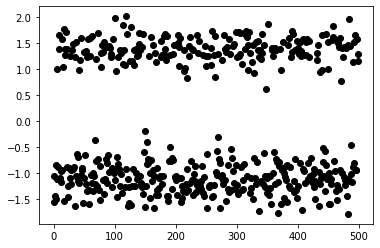

In [13]:
xA = sample1_OHE.filter(like='A', axis=1).values
xB = sample1_OHE.filter(like='B', axis=1).values
xA = Variable(torch.from_numpy(xA))
xB = Variable(torch.from_numpy(xB))

np_zA = np.empty(0)
for x in xA:
  zA = VAE_MRF.latent(x.float(), attribute='A')
  #print(z)
  np_zA = np.concatenate((np_zA, zA.cpu().detach().numpy()))
np_zA = np_zA.reshape(num_samples,latent_dims)

if latent_dims==1:
  plt.plot(np_zA, 'o', color='black');
elif latent_dims ==2:
  plt.plot(np_zA[:,0], np_zA[:,1],'o', color='black');
elif latent_dims ==3:
  from mpl_toolkits.mplot3d import Axes3D
  fig = plt.figure()
  ax = Axes3D(fig)
  #t = np.arange(1000)
  ax.scatter(np_zA[:,0], np_zA[:,1], np_zA[:,2])

# Query P(B|A=0).
##Ground truth: 

P(B=0|A=0) = 0.75

P(B=1|A=0) = 0.25


Feed nothing into B encoder.

In [14]:
xA_evidence = x_test[0] #Evidence is A=0
xA_evidence = xA_evidence.repeat(10000,1)
print('A evidence input, first 5 rows')
print(xA_evidence[0:5]) #need to resize/ view for single sample, or make evidence a batch repeated

xB_query = VAE_MRF.query_single_attribute(x_evidence=xA_evidence.float(), evidence_attribute = 'A')
print('B query output:')
print(np.round(xB_query[0:5].cpu().detach().numpy(),decimals=2))
print(xB_query.size())

#Averaging all xB_query
print('xB_query mean of each column:')
print(torch.mean(xB_query,0))

#Taking max of each row in xB_query and counting times each element is max
print('xB_query count of when each column is max:')
_,indices_max =xB_query.max(dim=1) 
#print(indices_max.numpy())
unique, counts = np.unique(indices_max.numpy(), return_counts=True)
dict(zip(unique, counts))

A evidence input, first 5 rows
tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]], dtype=torch.float64)
zA
tensor([[1.2661],
        [1.2524],
        [1.2469],
        ...,
        [1.6106],
        [1.6156],
        [1.5266]])
zB
tensor([[ 0.1998],
        [ 0.2936],
        [-0.5521],
        ...,
        [-0.0917],
        [ 0.1400],
        [-0.0606]], grad_fn=<SqueezeBackward1>)
B query output:
[[0.89 0.11]
 [0.96 0.04]
 [0.   1.  ]
 [0.89 0.11]
 [0.06 0.94]]
torch.Size([10000, 2])
xB_query mean of each column:
tensor([0.6159, 0.3841], grad_fn=<MeanBackward1>)
xB_query count of when each column is max:


{0: 6288, 1: 3712}

# Query P(B|A=1), 
## Groundtruth: 

P(B=0|A=1) = 1/3

P(B=1|A=1) = 2/3

In [15]:
xA_evidence = x_test[1+duplicates] #Evidence is A=1
xA_evidence = xA_evidence.repeat(10000,1)
print('A evidence input, first 5 rows')
print(xA_evidence[0:5]) #need to resize/ view for single sample, or make evidence a batch repeated

print('B query output:')

xB_query = VAE_MRF.query_single_attribute(x_evidence=xA_evidence.float(), evidence_attribute = 'A')
#
print("xB reconstruction")
print(np.round(xB_query[0:5].cpu().detach().numpy(),decimals=2))
#print(xB_query.size())

#Averaging all xB_query
print('xB_query mean of each column:')
print(torch.mean(xB_query,0))

#Taking max of each row in xB_query and counting times each element is max
print('xB_query count of when each column is max:')
_,indices_max =xB_query.max(dim=1) 
#print(indices_max.numpy())
unique, counts = np.unique(indices_max.numpy(), return_counts=True)
dict(zip(unique, counts))

A evidence input, first 5 rows
tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]], dtype=torch.float64)
B query output:
zA
tensor([[-0.5986],
        [-1.6072],
        [-0.9009],
        ...,
        [-0.8804],
        [-1.5650],
        [-0.6539]])
zB
tensor([[-0.1793],
        [-0.5700],
        [ 0.1266],
        ...,
        [-0.1559],
        [-0.1203],
        [ 0.1628]], grad_fn=<SqueezeBackward1>)
xB reconstruction
[[0.11 0.89]
 [0.   1.  ]
 [0.78 0.22]
 [0.07 0.93]
 [0.02 0.98]]
xB_query mean of each column:
tensor([0.3224, 0.6776], grad_fn=<MeanBackward1>)
xB_query count of when each column is max:


{0: 2986, 1: 7014}

Notice that the VAE_MRF can answer the query, but not as accurately as ppandas.

# Query P(B|A=1,B=1)
Feed both A and B, correctly identifies correct B

In [16]:
xA_evidence = x_test[1] #Evidence is A=1
xA_evidence = xA_evidence.repeat(1000,1)

xB_evidence = x_test[1] #Evidence is A=1
xB_evidence = xB_evidence.repeat(10000,1)

xB_query,_,_ = VAE_MRF.forward(xA_evidence.float(),xB_evidence.float(), 'A')
print(np.round(xB_query[0:5].cpu().detach().numpy(),decimals=2))
print(xB_query.size())

#Averaging all xB_query
print('xB_query mean of each column:')
print(torch.mean(xB_query,0))

#Taking max of each row in xB_query and counting times each element is max
print('xB_query count of when each column is max:')
_,indices_max =xB_query.max(dim=1) 
#print(indices_max.numpy())
unique, counts = np.unique(indices_max.numpy(), return_counts=True)
dict(zip(unique, counts))

[[0.08 0.92]
 [0.   1.  ]
 [0.07 0.93]
 [0.1  0.9 ]
 [0.98 0.02]]
torch.Size([10000, 2])
xB_query mean of each column:
tensor([0.2875, 0.7125], grad_fn=<MeanBackward1>)
xB_query count of when each column is max:


{0: 2501, 1: 7499}

#Query P(A|B= -1)
Try feeding into B encoder negative ones.

In [17]:
xA_evidence = x_test[0] #Evidence is A=0
xA_evidence = xA_evidence.repeat(1000,1)
xB = torch.tensor([0,0])
#xB = torch.tensor([0,0,0,0,0,0,0,0])
#xB = torch.tensor([0,0,0,0,0,0,0,1]) # if feed in valid input, get correct result
xB = xB.repeat(1000,1)

xB_query,_,_ = VAE_MRF.forward(xA_evidence.float(),xB.float(), attribute='B')
print(xB_query.size())
#Averaging all xB_query
print('xB_query mean of each column:')
print(torch.mean(xB_query,0))


torch.Size([1000, 2])
xB_query mean of each column:
tensor([0.6082, 0.3918], grad_fn=<MeanBackward1>)


- No matter xA evidence, if B encoder always given -1's B decoder same xB
- No matter xA evidence, if B encoder always given 0's B decoder returns same xB
- If feed in valid xB as evidence, then get correct xB as expected

# Querying the VAE-MRF
Once  the VAE-MRF is trained, to query P(B|A=0=(1,0,0,0,0,0,0,0))
- Feed $x_A$ into the A encoder to obtain $\mu_A, \Sigma_A$
- Sample $z_A$ using $\mu_A, \Sigma_A$ (standard VAE reparameterization trick)
- Since no input $x_B$ to the B encoder, assume $\mu_B, \Sigma_B$ come from the prior P(z) = Normal (0, Identity)
- Using $z_A, \mu_A, \Sigma_A, \mu_B, \Sigma_B$, sample $z_B$ from $P(z_B|z_A)$
- Feed $z_B$ into the B decoder to obtain $\hat{x}_B$ \\

Repeat, feeding in evidence $x_A$ multiple times to the VAE-MRF to obtain a probability distribution $P(\hat{x}_B|x_A)$

# Extension to Two Datasets AB and BC (not yet implemented)
$P(z_A,z_B,z_C) = Normal
\left(\left( \begin{array}{r} \mu_A \\ \mu_B \\ \mu_C \end{array} \right), 
\left[ \begin{array}{r} \Sigma_{A} & \Sigma_{AB} & 0 \\ \Sigma_{BA} & \Sigma_{B} & \Sigma_{BC}  \\ 0 & \Sigma_{CB} & \Sigma_{C} \end{array} \right] \right) $ 

In addition to the AB VAE-MRF: \\
  - $\mu_{C}$,  $\Sigma_{C}$ are the outputs of the C encoder \\
  -	$\Sigma_{BC}$ = $\Sigma_{CB}^T$ 

## Training the ABC VAE-MRF 
First sample $x_B$ from either the AB or BC dataset. Then using $x_B$, sample $x_A$ from the AB dataset and sample $x_C$ from the BC dataset.

- As given previously, feed $x_A, x_B$ to their respective encoders to obtain  $\mu_A, \Sigma_A,  \mu_B, \Sigma_B$ and obtain reconstructions $\hat{x_A}, \hat{x_B}$. Then sum the losses (reconstruction error and KL-divergence) from both A and B  and backpropagate once per batch

- Feed in $x_C$ and $x_B$ to their respective encoders to:
  - obtain $\mu_C, \Sigma_C$ from encoder C
  - obtain $\mu_B, \Sigma_B$ from encoder B

- To reconstruct $x_C$:
  - Sample $z_B$ using $\mu_B, \Sigma_B$ (standard VAE reparameterization trick)
  - Using $z_B,\mu_C, \Sigma_C, \mu_B, \Sigma_B$, sample $z_C$ from $P(z_C|z_B)$ (modified VAE reparameterization trick)
  - Feed $z_C$ into the C decoder to obtain the reconstruction $\hat{x}_C$ for $x_C$

- To reconstruct $x_B$:
  - Sample $z_C$ using $\mu_C, \Sigma_C$ (standard VAE reparameterization trick)
  - Using $z_C,\mu_C, \Sigma_C, \mu_B, \Sigma_B$, sample $z_B$ from $P(z_B|z_C)$ (modified VAE reparameterization trick)
  - Feed $z_B$ into the B decoder to obtain the reconstruction $\hat{x}_B$ for $x_B$

- Sum the losses (reconstruction error and KL-divergence) from both B and C  and backpropagate once per batch

## Querying the ABC VAE-MRF
Once  the VAE-MRF is trained, to query P(C|A=0=(1,0,0,0,0,0,0,0))
- Feed $x_A$ into the A encoder to obtain $\mu_A, \Sigma_A$
- Sample $z_A$ using $\mu_A, \Sigma_A$ (standard VAE reparameterization trick)
- Since no input $x_B, x_C$ to the B or C encoders, assume $\mu_B, \Sigma_B$ and $\mu_C, \Sigma_C$ come from the prior P(z) = Normal (0, Identity)
- Using $z_A, \mu_A, \Sigma_A, \mu_B, \Sigma_B$, sample $z_B$ from $P(z_B|z_A)$
- Using $z_B, \mu_C, \Sigma_C, \mu_B, \Sigma_B$, sample $z_C$ from $P(z_C|z_B)$
- Feed $z_C$ into the C decoder to obtain $\hat{x}_C$ \\

Repeat, feeding in evidence $x_A$ multiple times to the VAE-MRF to obtain a probability distribution $P(\hat{x}_B|x_A)$

# Notes

A symmetric matrix is positive definite if:

- all the diagonal entries are positive, and
- each diagonal entry is greater than the sum of the absolute values of all other entries in the corresponding row/column.


# Questions and Notes

Requires alternating between AB and BC samples where B is the same.

Have a separate plate for each dataset.
In Bayesian network, need to learn P(B),P(A|B), P(C|B). \\
In MRF need to learn factors $\phi(A,B)$ and $\phi(B,C)$.

How to handle datasets with 3 dimensions.
Latent edges between A,B,C (clique)?

Do we need to incorporate the parition function Z? If want probabilities that sum to 1 then yes. But if just looking to have input into the decoders then normalizing isn't necessary?

Koller Definition 4.3: \\
$Z = \sum_{AB,BC} \phi(A,B) \times \phi(B,C)$ \\
$P(A,B,C) = \frac{1}{Z} \phi(A,B) \times \phi(B,C)$ 

# To Do

- Query P(A|B=0)
- Add BC Plate
- Visualize latent space
- Try more than 1 sample when sampling zA and zB
- During training, try reconstructing A given only x_B and reconstructing B given only x_A. I believe feeding in A (and B) to reconstruct A during train time does not match what is required of the model during test time where we feed in only B to reconstruct A.
- Modifying variational_beta to lowest value that reconstructions were valid did not change ressults (0.0001), any higher variational_beta gave poor reconstructions.
- Check if training on only A improves performance
- Formalize in Overleaf
- Answer general research questions
- Try different likelihood functions (bernoulli, gaussian)
